### 🚨 **Important Notice** 🚨   
The content in this notebook is entirely derived from the Coursera course [**"Neural Networks and Deep Learning"**](https://www.coursera.org/learn/neural-networks-deep-learning) by **Andrew Ng**. I do not claim ownership of this material, and it is shared solely for educational purposes. I am not monetizing or selling this content, nor am I presenting it as my own work. All intellectual property and credit belong to the course creators, and this notebook is intended for personal learning and non-commercial use.

---

### **Additional Details**
- The course is part of the **Deep Learning Specialization**, which is offered by **DeepLearning.AI**.
- All rights and credits for the content belong to **Andrew Ng**, **DeepLearning.AI**, and **Coursera**.
- For further learning, check out the course [here](https://www.coursera.org/learn/neural-networks-deep-learning).

---

### **Acknowledgments**
🙏 Special thanks to **Andrew Ng** and the **DeepLearning.AI** team for creating such an incredible learning resource.



<a name='1'></a>
## 1 - Packages ##

- [numpy](https://numpy.org/doc/1.20/) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](https://pillow.readthedocs.io/en/stable/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline
%load_ext autoreload
%autoreload 2

<a name='2'></a>
## 2 - Overview##

Dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


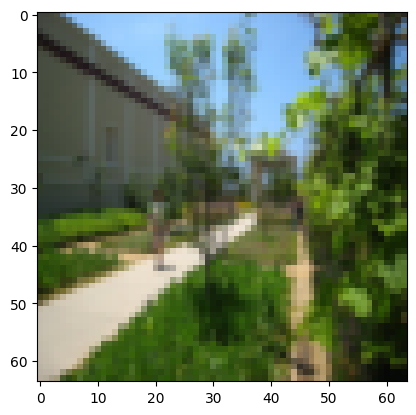

In [5]:
# Example of a picture
index = 8            #0-208
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [6]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td> m_train </td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>m_test</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>num_px</td>
    <td> 64 </td> 
  </tr>
  
</table>


For convenience, reshaping image shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

In [9]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


# Check that the first 10 pixels of the second image are in the correct place

try:
    assert np.all(train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213])
    assert np.all(test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159])
except AssertionError:
    print("\nWrong solution. Use (X.shape[0], -1).T.\n\n")

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>train_set_x_flatten shape</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>train_set_y shape</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>test_set_x_flatten shape</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>test_set_y shape</td>
    <td>(1, 50)</td> 
  </tr>
</table>

**Standardizing Dataset:**

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

Usually you subtract the mean of whole numpy array from each example and divide it by standard deviation of the whole numpy array.
But for picture datasets, its simpler to divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [10]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

<a name='3'></a>
## 3 - General Architecture of the learning algorithm ##

Designing a simple algorithm to distinguish cat images from non-cat images.

Building a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

<a name='4'></a>
## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

We build 1-3 separately and integrate them into one function we call `model()`.

<a name='4-1'></a>
### 4.1 - Helper functions

<a name='ex-3'></a>
### Sigmoid
Compute $sigmoid(z) = \frac{1}{1 + e^{-z}}$ for $z = w^T x + b$ to make predictions.

In [11]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    
    s = 1/(1+np.exp(-z))
    
    return s

In [13]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


<a name='4-2'></a>
### 4.2 - Initializing parameters

<a name='ex-4'></a>
### Initialize_with_zeros
Initializing w as a vector of zeros.

In [14]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    
    w = np.zeros((dim,1))
    b = 0.0

    return w, b

In [15]:
dim = 2
w, b = initialize_with_zeros(dim)

assert type(b) == float
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


<a name='4-3'></a>
### 4.3 - Forward and Backward propagation

Time for "forward" and "backward" propagation steps for learning the parameters.

<a name='ex-5'></a>
### Propagate
Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [16]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    grads -- dictionary containing the gradients of the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    cost -- negative log-likelihood cost for logistic regression
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)
    cost = -(1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)
    

    cost = np.squeeze(np.array(cost))

    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [18]:
w =  np.array([[1.], [2]])
b = 1.5

# X is using 3 examples, with 2 features each
# Each example is stacked column-wise
X = np.array([[1., -2., -1.], [3., 0.5, -3.2]])
Y = np.array([[1, 1, 0]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64


print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.1250040450043965
cost = 0.15900537707692405


**Expected output**

```
dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.1250040450043965
cost = 0.15900537707692405
```

<a name='4-4'></a>
### 4.4 - Optimization
Now, update the parameters using gradient descent.

<a name='ex-6'></a>
### Optimize
Learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [19]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [20]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))

w = [[0.80956046]
 [2.0508202 ]]
b = 1.5948713189708588
dw = [[ 0.17860505]
 [-0.04840656]]
db = -0.08888460336847771
Costs = [array(0.15900538)]


<a name='ex-7'></a>
### Predict

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`.

In [21]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture    
    A = sigmoid(np.dot(w.T,X)+b)
    
    
    for i in range(A.shape[1]):        
        Y_prediction = (A > 0.5).astype(int)

    
    return Y_prediction

In [22]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1 1 0]]


<a name='5'></a>
## 5 - Merge all functions into a model ##

<a name='ex-8'></a>
### Model

In [23]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    w, b = initialize_with_zeros(X_train.shape[0])
    
    params, grads,costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = params["w"]
    b = params["b"]
    
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)


    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [25]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 0, you predicted that it is a "non-cat" picture.


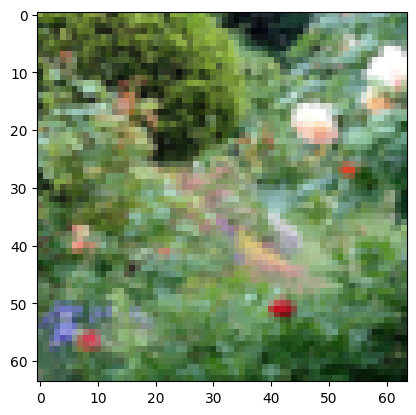

In [26]:
# Example of a picture that was wrongly classified.
index = 49    #0-49
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

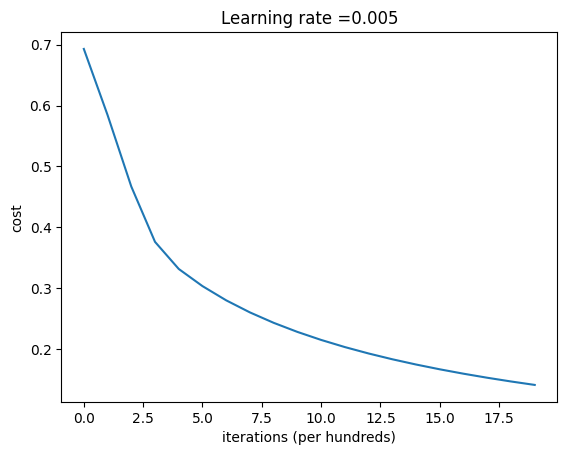

In [27]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

<a name='6'></a>
## 6 - Further analysis##

Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens. 

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



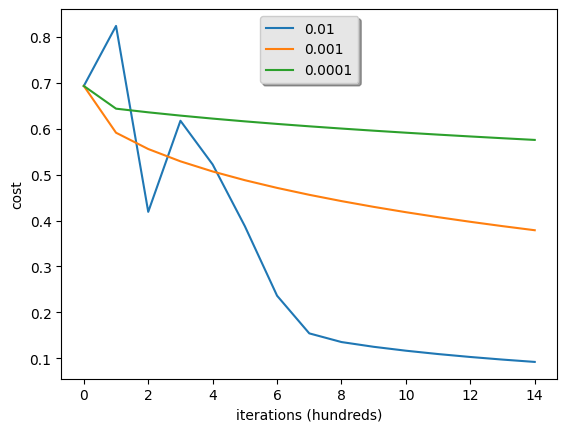

In [28]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting.


<a name='7'></a>
## 7 - Test with your own image##

Use your own image and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Change your image's name in the following code
    4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

y = 0, your algorithm predicts a "non-cat" picture.


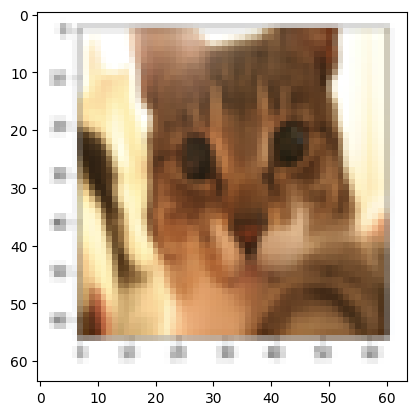

In [33]:
# Change this to the name of your image file
my_image = "12345.png"

# We preprocess the image to fit your algorithm.
try:
    fname = "images/" + my_image
    image = Image.open(fname).resize((num_px, num_px))
    image = image.convert('RGB')  # Convert to RGB before converting to numpy array
    image = np.array(image)

    plt.imshow(image)

    image = image / 255.0
    image = image.reshape((1, num_px * num_px * 3)).T

    my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

    print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image))].decode("utf-8") + "\" picture.")

except FileNotFoundError:
    print("File is missing")

Finally, if you'd like, we invite you to try different things on this Notebook. Make sure you submit before trying anything. Once you submit, things you can play with include:
    - Play with the learning rate and the number of iterations
    - Try different initialization methods and compare the results
    - Test other preprocessings (center the data, or divide each row by its standard deviation)

Bibliography:
- https://www.coursera.org/learn/neural-networks-deep-learning
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c